In [3]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'



import jax
import jax.numpy as jnp
import numpy as np
from jax import random 
from jax import grad, vmap, jit, lax

jax.config.update('jax_platform_name', 'cpu')

from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns


from potentials import *
from metrics import *
from underdamped_util import *

from functools import partial


mpl.style.use("seaborn-v0_8")
from scipy.stats import norm


In [4]:
# NOTE: only for gaussian f(x)!!
# ###############################
#  
@partial(jit, static_argnames=('n_steps',))
def underdamped_langevin(key, x0, n_steps, h, gamma, mean, cov_inv):
    sqrt_2_gamma_h = jnp.sqrt(2 * gamma * h)
    friction_factor = 1 - h * gamma
    
    key, subkey = jax.random.split(key)
    v0 = jax.random.normal(subkey, x0.shape)

    key, subkey = jax.random.split(key)
    noise_keys = jax.random.split(subkey, n_steps)
    noises = sqrt_2_gamma_h * jax.vmap(lambda k: jax.random.normal(k, x0.shape))(noise_keys)

    def step(carry, noise):
        x, v = carry
        
        grad_u = cov_inv @ (x - mean)
        
        v_new = friction_factor * v - h * grad_u + noise
        x_new = x + h * v
        
        return (x_new, v_new), jnp.stack([x_new, v_new])
    
    carry_init = (x0, v0)
    _, samples = lax.scan(step, carry_init, noises)
    
    return samples

In [5]:

key = jax.random.PRNGKey(42)
n_steps = 250_000

mean = jnp.array([0., 0.]) 

mean_full = jnp.concatenate((mean, jnp.zeros((2, ))))

ndim=2
cov = jnp.array([[1., 0.],   
                 [0., 1.]])  

cov_full = jnp.zeros((2*ndim, 2*ndim))

cov_full = jnp.zeros((2*ndim, 2*ndim))
cov_full = cov_full.at[0:ndim, 0:ndim].set(cov)
cov_full = cov_full.at[ndim:, ndim:].set(jnp.eye(ndim, ndim))

z0 = jnp.array([0.0, 0.0])

samples = underdamped_langevin(key, z0, n_steps, 5e-2, 2., mean, cov)


joint_samples = samples.reshape(n_steps, -1)
print("2D Sample mean:", jnp.mean(joint_samples, axis=0))          
print("2D Sample covariance:\n", jnp.cov(joint_samples, rowvar=False))         

2D Sample mean: [-7.4198293e-03  3.5144486e-03 -6.1670544e-05  4.2091706e-05]
2D Sample covariance:
 [[ 1.0559690e+00 -8.6005498e-03 -2.7211750e-02 -4.6074861e-03]
 [-8.6005498e-03  1.0396396e+00  4.5957449e-03 -2.6779724e-02]
 [-2.7211750e-02  4.5957449e-03  1.0891918e+00 -3.1657791e-04]
 [-4.6074861e-03 -2.6779724e-02 -3.1657791e-04  1.0716054e+00]]


In [ ]:
stepsizes = jnp.logspace(-2, 0, 8, endpoint=False)
tfinal = 1.e6

errs = []


ndim=4
# mean = jnp.array([0., 0.]) 

mean = jnp.zeros(ndim)
mean_full = jnp.concatenate((mean, jnp.zeros((ndim, ))))

# cov = jnp.array([[1., 0.],   
                #  [0., 1.]])  

cov = jnp.eye(ndim, ndim)

cov_full = jnp.zeros((2*ndim, 2*ndim))

cov_full = jnp.zeros((2*ndim, 2*ndim))
cov_full = cov_full.at[0:ndim, 0:ndim].set(cov)
cov_full = cov_full.at[ndim:, ndim:].set(jnp.eye(ndim, ndim))

# z0 = jnp.array([0.0, 0.0])
z0 = jnp.zeros((ndim, ))

for h in stepsizes: 
    nsteps = int(tfinal/h)

    samples = underdamped_langevin(key, z0, nsteps, h, 2., mean, cov)
    joint_samples = samples.reshape(nsteps, -1)

    errs.append(wasserstein_gaussian(joint_samples, mean_full, cov_full))

Text(0.1, 0.05, 'Slope$=1$')

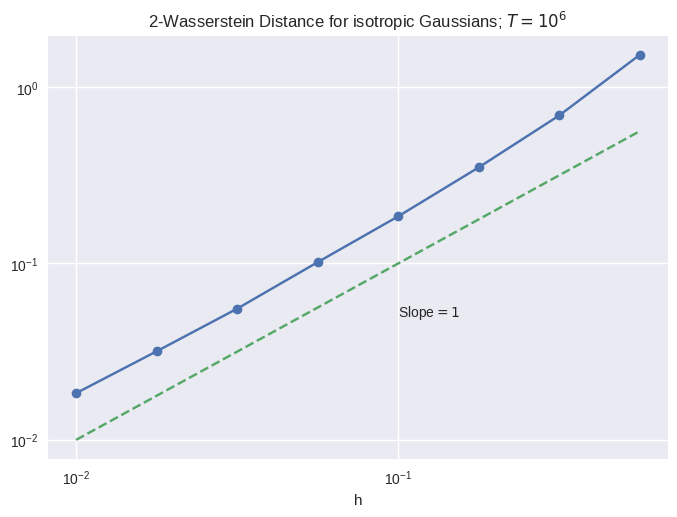

In [7]:
plt.loglog(stepsizes, errs, '-o')

plt.title(r"2-Wasserstein Distance for isotropic Gaussians; $T = 10^6$")
plt.xlabel("h")
plt.plot(stepsizes, stepsizes, '--')
plt.annotate(r"Slope$=1$", (0.1, 5e-2))

In [ ]:
def create_scaled_system(D):
    mean_x = jnp.ones(D)
    mean_full = jnp.concatenate([mean_x, jnp.zeros(D)])
    
    cov_x = jnp.eye(D)
    # cov_full = jnp.kron(jnp.eye(2), jnp.eye(D))
    cov_full = jnp.block(
        [
                    [cov_x, jnp.zeros((D, D))], 
                    [jnp.zeros((D, D)), jnp.eye(D)]
        ]
                )

    return mean_x, cov_x, mean_full, cov_full

def create_scaled_system_random(D, key):
    key_mean, key_cov = jax.random.split(key)
    
    mean_x = jax.random.normal(key_mean, (D,))
    
    A = jax.random.normal(key_cov, (D, D))
    cov_x = jnp.dot(A, A.T)  # A @ A.T ensures cov_x is positive semi-definite
    
    mean_full = jnp.concatenate([mean_x, jnp.zeros(D)])
    
    cov_full = jnp.block(
        [
            [cov_x, jnp.zeros((D, D))], 
            [jnp.zeros((D, D)), jnp.eye(D)]
        ]
    )
    
    return mean_x, cov_x, mean_full, cov_full

@partial(jit, static_argnames=('D', 'n_steps'))
def simulate_dimension(key, D, n_steps, h, gamma):
    # mean_x, cov_x, mean_full, cov_full = create_scaled_system(D)
    key, subkey = jax.random.split(key)

    mean_x, cov_x, mean_full, cov_full = create_scaled_system_random(D, subkey)

    # cov_inv = jnp.linalg.inv(cov_full)  
    
    key, subkey = jax.random.split(key)
    z0 = jax.random.normal(subkey, (D,))
    # z0 = jnp.zeros((D, ))

    samples = underdamped_langevin(key, z0, n_steps, h, gamma, mean_x, jnp.linalg.inv(cov_x)) # 
    
    joint_samples = samples.reshape(n_steps, 2*D)

    return wasserstein_gaussian(joint_samples, mean_full, cov_full) # [100_000:]

In [25]:
key = jax.random.PRNGKey(32)
mean_x, cov_x, mean_full, cov_full = create_scaled_system_random(2, key)

simulate_dimension(key, 2, n_steps, 1e-3, 1.)

Array(0.2817373, dtype=float32)

In [ ]:
# dims = [2**k for k in range(0, 6)] 
dims = [2, 5,  25, 50, 100]
gamma = 2.
h = 1e-3
n_replicates = 5

n_steps = 100_000
# n_steps = 250_000
# n_steps = 1.e6

def benchmark_all_dims(key):
    results = []
    for D in dims:
        # mean_x, cov_x, mean_full, cov_full = create_scaled_system(D)
        # cov_inv = jnp.linalg.inv(cov_full)
        
        sim_partial = partial(simulate_dimension, 
                            D=D, 
                            n_steps=n_steps, 
                            h=h, 
                            gamma=gamma,
                            # cov_inv=cov_inv
                            )
        
        keys = jax.random.split(key, n_replicates)
        w2 = jax.vmap(sim_partial)(keys)
        results.append(w2)
        key = keys[-1]  # Use last key for next dimension
        

    return jnp.array(results)

In [7]:
key = jax.random.PRNGKey(404)

w2_results = benchmark_all_dims(key)